# Credit Card Fraud Detection using Homomorphic Encryption Neural Network

This notebook is a proof of concept of running a credit card (CC) fraud detection neural network on encrypted data. A plaintext neural network is first trained using [PyTorch](https://pytorch.org/), and then a private network uses these weights to perform homomorphic encryption (HE) operations with [TenSEAL](https://github.com/OpenMined/TenSEAL). Included in the aims were to keep computation costs down by using a low-layer neural network.

In [132]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import torch
from sklearn import metrics
import tenseal as ts

## Dataset

The dataset used is the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset created by Machine Learning Group - ULB. It consists of 284,807 transactions, 492 of which are fraudulant. 

Each transaction has 30 pieces of information, and a Class of 0 for *valid* or 1 for *fraudulant*. All column names other than Time and Amount have been obfuscated for privacy. In our case, the dataset may not need to have obfuscated column names, as the network could potentially be trained on encrypted data.

In [133]:
# Show the first row of the dataset
data = pd.read_csv('./data/creditcard.csv')
print(data.head(1))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  

[1 rows x 31 columns]


The percentage of fraudulant transactions in the dataset is very low, which is something we may consider in the design of our network.

Percentage of fraudulant transactions: 0.17%


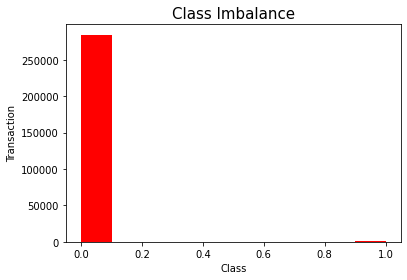

In [134]:
# The percentage of fraudulant transactions in the dataset is very low, which is something we may consider in the
# design of our network.
print('Percentage of fraudulant transactions: {:.2f}%'.format(pc_fraud*100))
plt.hist(data['Class'], color='red')
plt.xlabel('Class')
plt.ylabel('Transaction')
plt.title('Class Imbalance', fontsize=15)
plt.show()
pc_fraud = len(data.loc[data['Class'] == 1].values)/len(data.loc[data['Class'] == 0].values)

The data is then preprocessed and split into a dataset for training the network and a dataset for testing it.

In [88]:
# Preprocessing the data by scaling into a [0,1] range and splitting into inputs x and outputs y
x = data.drop('Class', axis=1).values
y = data['Class'].values
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)

# Splitting the data into a dataset for training the network and a dataset for testing it
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

print('Distribution of each dataset:')
print('Train: %s' % Counter(ytrain))
print('Test: %s' % Counter(ytest))

Distribution of each dataset:
Train: Counter({0: 227454, 1: 391})
Test: Counter({0: 56861, 1: 101})


In [89]:
# Dataloaders setup, batch size of 100
train_ds = torch.utils.data.TensorDataset(torch.tensor(xtrain).float(), torch.tensor(ytrain).float())
test_ds = torch.utils.data.TensorDataset(torch.tensor(xtest).float(), torch.tensor(ytest).float())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=100)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=100)

## Plaintext PyTorch model for training

A simple feedforward classifier neural network is trained on the training set using PyTorch, so that we can find the optimum weights to use in our HE Model. This is referred to as the *Plaintext Model*. Other options for neural networks include autoencoders. Out of all the low-layer networks found online trained on this dataset, a simple feedforward classifier seemed to perform best.

**Network shape:**
* input size is (1, 30)
* hidden linear layer of size (30, 15)
* output linear layer of size (15, 1)
* output size is (1, 1)

In [135]:
# Plaintext Model
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = torch.nn.Linear(30, 15)
        self.output_layer = torch.nn.Linear(15, 1)

    def forward(self, x, show=False):
        self.show = show
        self.debug_output('Input', x)
        y = self.hidden_layer(x)
        self.debug_output('Hidden Layer', y)
        y = y * y
        self.debug_output('Activation', y)
        y = self.output_layer(y)
        self.debug_output('Output Layer', y)
        return y.squeeze()
    
    def debug_output(self, msg, vec):
        if self.show:
            print(msg)
            print(vec)

In [91]:
# Training functions
def train(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [93]:
# Plaintext Model
model = Classifier()

The Plaintext Model is trained for 100 epochs on the training set. Once training has been completed once, saved model weights can be loaded.

In [95]:
# Training (commented out once training is done and model weights are saved)
# pos_weight = torch.tensor([5])
# opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# n_epoch = 100

# train(n_epoch,model,loss_func,opt,train_dl,valid_dl)
# torch.save(model.hidden_layer, './data/fhe-compatible-model-hidden-layer.pt')
# torch.save(model.output_layer, './data/fhe-compatible-model-output-layer.pt')

In [136]:
model.hidden_layer = torch.load('./data/fhe-compatible-model-hidden-layer.pt')
model.output_layer = torch.load('./data/fhe-compatible-model-output-layer.pt')

An example of one of the datapoints in the test set passing through the Plaintext Model is now shown.

In [100]:
model(torch.tensor(xtest[0]).float(), show=True)

Input
tensor([0.7282, 0.9528, 0.7784, 0.8366, 0.2250, 0.7742, 0.2621, 0.2724, 0.7841,
        0.4568, 0.4747, 0.2188, 0.7118, 0.5370, 0.5855, 0.3178, 0.4474, 0.7557,
        0.6794, 0.6295, 0.5823, 0.5581, 0.4898, 0.6615, 0.3759, 0.5898, 0.4268,
        0.4185, 0.3164, 0.0016])
Hidden Layer
tensor([ 1.1345,  1.5043, -2.1212, -0.0782,  0.1497,  0.5256, -2.6513, -0.0276,
         0.1480, -0.1862,  0.1435, -2.8860,  0.2541,  1.1515, -1.1065],
       grad_fn=<AddBackward0>)
Activation
tensor([1.2872e+00, 2.2629e+00, 4.4997e+00, 6.1219e-03, 2.2415e-02, 2.7621e-01,
        7.0296e+00, 7.6110e-04, 2.1890e-02, 3.4684e-02, 2.0595e-02, 8.3291e+00,
        6.4586e-02, 1.3260e+00, 1.2243e+00], grad_fn=<MulBackward0>)
Output Layer
tensor([-7.2862], grad_fn=<AddBackward0>)


tensor(-7.2862, grad_fn=<SqueezeBackward0>)

## Private Model using Homomorphic Encryption

Model which uses HE operations for each layer. It has the same shape as the Plaintext Model so it can be initialised with the weights found in training. The encryption, matrix multiplications, addition and decryption are done using TenSEAL. This network is referred to as the *HE Model*.

In [101]:
# HE Model
class HEModel:
    def __init__(self, hidden_layer, output_layer):
        self.hidden_layer_weight = hidden_layer.weight.t().tolist()
        self.hidden_layer_bias = hidden_layer.bias.tolist()
        self.output_layer_weight = output_layer.weight.t().tolist()
        self.output_layer_bias = output_layer.bias.tolist()
        
    def forward(self, enc_x, show=False, plaintext=False):
        self.show = show
        self.plaintext = plaintext
        self.debug_output('Input', enc_x)
        enc_y = enc_x.mm(self.hidden_layer_weight) + self.hidden_layer_bias
        self.debug_output('Hidden Layer', enc_y)
        enc_y *= enc_y
        self.debug_output('Activation', enc_y)
        enc_y = enc_y.mm(self.output_layer_weight) + self.output_layer_bias
        self.debug_output('Output Layer', enc_y)
        return enc_y
    
    def debug_output(self, msg, vec):
        if self.show:
            print(msg)
            if self.plaintext: vec = torch.tensor(vec.decrypt())
            print(vec)
    
    def __call__(self, enc_x, show=False, plaintext=False):
        return self.forward(enc_x, show, plaintext)

The CKKS HE scheme is used. This allows for operations to be done on full tensors at a time.

More information on CKKS can be found in OpenMined's [CKKS Explained Series](https://blog.openmined.org/ckks-explained-part-1-simple-encoding-and-decoding/).

In [137]:
# TenSEAL CKKS HE encryption scheme context setup
bits_scale = 40
coeff_mod_bit_sizes = [60, bits_scale, bits_scale, bits_scale, 60]
polynomial_modulus_degree = 8192*2

# Create context
context = ts.context(ts.SCHEME_TYPE.CKKS, polynomial_modulus_degree, coeff_mod_bit_sizes=coeff_mod_bit_sizes)
# Set global scale
context.global_scale = 2**bits_scale
# Generate galois keys required for matmul in ckks_vector
context.generate_galois_keys()

The HE Model is initialised with the weights acquired from the training of the Plaintext Model

In [103]:
he_model = HEModel(model.hidden_layer, model.output_layer)

An example of one of the datapoints in the test set being encrypted and then passed through the HE Model is now shown. As the layers in the model use HE, each output is an encrypted CKKS vector.

In [104]:
# Example of encrypted test datapoint passing through the HE Model
enc_input = ts.ckks_vector(context, xtest[0])
he_model(enc_input, show=True)

Input
Hidden Layer
Activation
Output Layer


For demonstration purposes, a decrypted version of this debug output is shown in order to sanity check that the data is passing through the HE Model the same way it passes through the Plaintext Model. When compared with the previously shown output of the Plaintext Model, it is confirmed that they are the same.

In a production environment, the server running the network would not have the private key required to decrypt the data.

In [105]:
# Example of encrypted test datapoint passing through the HE Model, showing each stage decrypted
he_model(enc_input, show=True, plaintext=True)

Input
tensor([0.7282, 0.9528, 0.7784, 0.8366, 0.2250, 0.7742, 0.2621, 0.2724, 0.7841,
        0.4568, 0.4747, 0.2188, 0.7118, 0.5370, 0.5855, 0.3178, 0.4474, 0.7557,
        0.6794, 0.6295, 0.5823, 0.5581, 0.4898, 0.6615, 0.3759, 0.5898, 0.4268,
        0.4185, 0.3164, 0.0016])
Hidden Layer
tensor([ 1.1345,  1.5043, -2.1212, -0.0782,  0.1497,  0.5256, -2.6513, -0.0276,
         0.1480, -0.1862,  0.1435, -2.8860,  0.2541,  1.1515, -1.1065])
Activation
tensor([1.2872e+00, 2.2629e+00, 4.4997e+00, 6.1220e-03, 2.2415e-02, 2.7621e-01,
        7.0296e+00, 7.6110e-04, 2.1890e-02, 3.4685e-02, 2.0595e-02, 8.3292e+00,
        6.4586e-02, 1.3261e+00, 1.2243e+00])
Output Layer
tensor([-7.2863])


HE operations are much slower than standard plaintext operations. The time difference of an inference using the Plaintext Model and the HE Model are shown below.

In [109]:
# Time difference between Plaintext Model and HE Model
%time model(torch.tensor(xtest[0]).float())
%time he_model(enc_input)

CPU times: user 5.25 ms, sys: 2 ms, total: 7.25 ms
Wall time: 3.73 ms
CPU times: user 8.77 s, sys: 9.26 ms, total: 8.78 s
Wall time: 1.51 s


## Evaluation

To validate that our Plaintext Model and our HE Model output the same values, we will evaluate a small subset of our test set with each network. Evaluating the full test set with our HE Model would take a lot of time, so we can leave the evaluation of the full test set to the Plaintext Model.

In [144]:
def evaluate_predictions(preds, truths):
    preds[preds>=0.5] = 1.0
    preds[preds<0.5] = 0.0
    conf_matrix = metrics.confusion_matrix(truths, preds)
    plt.figure(figsize=(5, 5))
    labels = ["Valid", "Fraud"]
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    print('AUPRC score: {}'.format(metrics.average_precision_score(truths, preds)))
    print('AUROC score: {}'.format(metrics.roc_auc_score(truths, preds)))
    print('Accuracy score: {}'.format(metrics.accuracy_score(truths, preds)))
    print(metrics.classification_report(truths, preds))

In [139]:
# We'll take the indices of all the fraudulant transactions in the test set
fraud_test_idxs = ytest==1
# And combine them with an extra 100 transactions
fraud_test_idxs[:100] = True

Evaluation of the sample with the Plaintext Model

AUPRC score: 0.8916309541401901
AUROC score: 0.8910891089108911
Accuracy score: 0.8905472636815921
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       1.00      0.78      0.88       101

    accuracy                           0.89       201
   macro avg       0.91      0.89      0.89       201
weighted avg       0.91      0.89      0.89       201



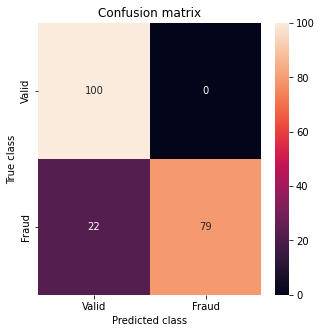

In [145]:
# Evaluate the sample with the Plaintext Model
results_plain = []
for x in xtest[fraud_test_idxs]:
    results_plain.append(model(torch.tensor(x).float()).detach().numpy())
results_plain = np.array(results_plain).squeeze()

evaluate_predictions(results_plain, ytest[fraud_test_idxs])

The most important intuitive metric shown above is the *Confusion matrix* which shows in this case that all 100 valid transactions were successfully labelled as valid, and 79 of the 101 fraudulant transactions were successfully labelled as fraudulant.

Next the sample is evaluated with the HE Model

AUPRC score: 0.8916309541401901
AUROC score: 0.8910891089108911
Accuracy score: 0.8905472636815921
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       1.00      0.78      0.88       101

    accuracy                           0.89       201
   macro avg       0.91      0.89      0.89       201
weighted avg       0.91      0.89      0.89       201



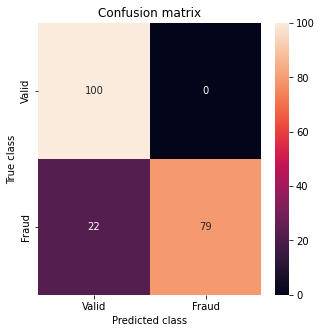

In [146]:
# Evaluation of the sample with the HE Model
results_encrypted = []
for x in xtest[fraud_test_idxs]:
    enc_input = ts.ckks_vector(context, x)
    enc_output = he_model(enc_input)
    res = enc_output.decrypt()
    results_encrypted.append(res)
results_encrypted = np.array(results_encrypted).squeeze()

evaluate_predictions(results_encrypted, ytest[fraud_test_idxs])

The same results are found. This demonstrates that the Plaintext Model and teh HE Model both output the same values.

Finally, the full test set is evaluated using the Plaintext Model. This will demonstrate the performance of the weights used in both models.

AUPRC score: 0.6648171816188314
AUROC score: 0.8909660016844969
Accuracy score: 0.9993679997191109
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.85      0.78      0.81       101

    accuracy                           1.00     56962
   macro avg       0.92      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



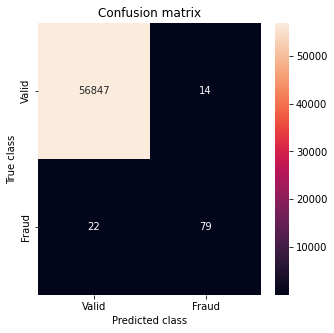

In [147]:
# Evaluation of the full test set with the Plaintext Model
results_plain = []
for x in xtest:
    results_plain.append(model(torch.tensor(x).float()).detach().numpy())
results_plain = np.array(results_plain).squeeze()

evaluate_predictions(results_plain, ytest)

As shown, 56847 of the 56861 valid transactions are successfully labelled as valid, and 79 of the 101 fraudulant transactions are successfully labelled as fraudulant.

Although these results are not perfect, it concludes the demonstration of how a model can be trained using PyTorch to identify fraudulant CC transactions and then converted into a model that can operate on encrypted inputs using HE.

Some functions for training and evaluation were adapted from this [Kaggle notebook](https://www.kaggle.com/rinabuoy/credit-card-fraud-detection-with-pytorch/notebook) on CC fraud detection.

The HE network is adapted from this official [TenSEAL tutorial](https://github.com/OpenMined/courses/blob/foundations-of-private-computation/homomorphic-encryption/Evaluation%20on%20Encrypted%20Data%20using%20TenSEAL%20-%20Solution.ipynb)